In [64]:
# Import the libraries
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import Birch
from sklearn.metrics import mean_squared_error, r2_score
#import shap
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
#pip install requests pandas
#pip install folium
#pip install statsmodels

In [65]:
# Import the data
df = pd.read_csv('kc_house_data.csv')
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [66]:
# Created a new feature that identifies transactions that are housing focused vs raw land focused.
# Computes the living space to lot space ratio.
# Ensure sqft_living and sqft_lot do not contain zeros to avoid division by zero errors
df = df[(df['sqft_living'] > 0) & (df['sqft_lot'] > 0)]

# Add a new feature 'living_to_lot_ratio' which is the ratio of 'sqft_living' to 'sqft_lot'
df['living_to_lot_ratio'] = df['sqft_living'] / df['sqft_lot']

# Verify the new feature
print(df[['sqft_living', 'sqft_lot', 'living_to_lot_ratio']].head())

   sqft_living  sqft_lot  living_to_lot_ratio
0         1180      5650             0.208850
1         2570      7242             0.354874
2          770     10000             0.077000
3         1960      5000             0.392000
4         1680      8080             0.207921


In [67]:
# Display summary statistics for the DataFrame
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

       ...    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  ...  21613.000000   21613.000000  21613.000000  21613.000000   
mean   ...   1788.390691     291.509045   1971.005136     84.402258   
std    ...    828.090978     442.575043     29.373411    401.679240   
min    ...    290.000000       0.000000   1900.000000      0.000000   
25%    ...   1190.000000       0.000000   1951.000000      0.000000   
50%    ...   1560.000000       0.000000   1975.000000      0.000000   
75%    ...   2210.000000     560.000000   1997.000000      0.000000   
max    ...   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  \
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000   
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652   
std       53.505026      0.138564      0.140828     685.391304   27304.179631   
min    98001.000000     47.155900   -122.519000     399.000000     651.000000   
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000   
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000   
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000   
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000   

       living_to_lot_ratio  
count         21613.000000  
mean              0.323745  
std               0.268565  
min               0.000610  
25%               0.156581  
50%               0.247664  
75%               0.407547  
max               4.653846  

[8 rows x 21 columns]

In [68]:
# Created filters to reduce outliers
df_filtered = df[(df['price'] <= 4999999) & (df['grade'] >= 2) & (df['bathrooms']>0) & (df['bedrooms']<15) & (df['living_to_lot_ratio']>.002)]

# Verify the removal
print(f"Number of rows before filtering: {len(df)}")
print(f"Number of rows after filtering: {len(df_filtered)}")

# Optional: Display the first few rows to verify
print(df_filtered.head())

Number of rows before filtering: 21613
Number of rows after filtering: 21591
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...        1180              0   
1      7242     2.0           0     0  ...        2170            400   
2     10000     1.0           0     0  ...         770              0   
3      5000     1.0           0     0  ...        1050            910   
4      8080     1.0           0     0  ...        1680              0   

   yr_built  yr

In [69]:
# Display summary statistics for the DataFrame
df_filtered.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159100e+04  2.159100e+04  21591.000000  21591.000000  21591.000000   
mean   4.580225e+09  5.383398e+05      3.370525      2.114701   2078.046918   
std    2.876395e+09  3.526453e+05      0.904669      0.765460    908.763966   
min    1.000102e+06  7.800000e+04      0.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  4.668000e+06     11.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159100e+04  21591.000000  21591.000000  21591.000000  21591.000000   
mean   1.493905e+04      1.494095      0.007410      0.233245      3.409615   
std    3.895740e+04      0.539758      0.085767      0.764224      0.650413   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.615000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.066450e+04      2.000000      0.000000      0.000000      4.000000   
max    1.074218e+06      3.500000      1.000000      4.000000      5.000000   

       ...    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  ...  21591.000000   21591.000000  21591.000000  21591.000000   
mean   ...   1786.988375     291.058543   1971.008105     84.303552   
std    ...    822.176045     441.125132     29.369261    401.455113   
min    ...    370.000000       0.000000   1900.000000      0.000000   
25%    ...   1190.000000       0.000000   1951.000000      0.000000   
50%    ...   1560.000000       0.000000   1975.000000      0.000000   
75%    ...   2210.000000     560.000000   1997.000000      0.000000   
max    ...   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  \
count  21591.000000  21591.000000  21591.000000   21591.000000   21591.000000   
mean   98077.971192     47.560066   -122.213981    1985.955676   12724.276828   
std       53.511597      0.138557      0.140740     684.278239   27096.635092   
min    98001.000000     47.155900   -122.519000     399.000000     651.000000   
25%    98033.000000     47.471050   -122.328000    1490.000000    5100.000000   
50%    98065.000000     47.571800   -122.231000    1840.000000    7620.000000   
75%    98118.000000     47.678000   -122.125000    2360.000000   10080.000000   
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000   

       living_to_lot_ratio  
count         21591.000000  
mean              0.323816  
std               0.268499  
min               0.002123  
25%               0.156665  
50%               0.247664  
75%               0.407667  
max               4.653846  

[8 rows x 21 columns]

In [70]:
# Display data types for each column
print(df_filtered.dtypes)

id                       int64
date                    object
price                  float64
bedrooms                 int64
bathrooms              float64
sqft_living              int64
sqft_lot                 int64
floors                 float64
waterfront               int64
view                     int64
condition                int64
grade                    int64
sqft_above               int64
sqft_basement            int64
yr_built                 int64
yr_renovated             int64
zipcode                  int64
lat                    float64
long                   float64
sqft_living15            int64
sqft_lot15               int64
living_to_lot_ratio    float64
dtype: object


In [71]:
# Detect missing values
na_counts = df_filtered.isna().sum()

# Display the count of missing values for each column
print(na_counts)

id                     0
date                   0
price                  0
bedrooms               0
bathrooms              0
sqft_living            0
sqft_lot               0
floors                 0
waterfront             0
view                   0
condition              0
grade                  0
sqft_above             0
sqft_basement          0
yr_built               0
yr_renovated           0
zipcode                0
lat                    0
long                   0
sqft_living15          0
sqft_lot15             0
living_to_lot_ratio    0
dtype: int64


In [72]:
# Remove Y and features not needed
X=df_filtered.drop(columns='price')
X.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7129300520  20141013T000000         3       1.00         1180      5650   
1  6414100192  20141209T000000         3       2.25         2570      7242   
2  5631500400  20150225T000000         2       1.00          770     10000   
3  2487200875  20141209T000000         4       3.00         1960      5000   
4  1954400510  20150218T000000         3       2.00         1680      8080   

   floors  waterfront  view  condition  ...  sqft_above  sqft_basement  \
0     1.0           0     0          3  ...        1180              0   
1     2.0           0     0          3  ...        2170            400   
2     1.0           0     0          3  ...         770              0   
3     1.0           0     0          5  ...        1050            910   
4     1.0           0     0          3  ...        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  living_to_lot_ratio  
0        5650             0.208850  
1        7639             0.354874  
2        8062             0.077000  
3        5000             0.392000  
4        7503             0.207921  

[5 rows x 21 columns]

In [73]:
y=df_filtered['price'].values.reshape(-1,1)
y

array([[221900.],
       [538000.],
       [180000.],
       ...,
       [402101.],
       [400000.],
       [325000.]])

In [74]:
# Ensure the zipcode column is of type int64
X['zipcode'] = X['zipcode'].astype('int64')

In [75]:
X.dtypes

id                       int64
date                    object
bedrooms                 int64
bathrooms              float64
sqft_living              int64
sqft_lot                 int64
floors                 float64
waterfront               int64
view                     int64
condition                int64
grade                    int64
sqft_above               int64
sqft_basement            int64
yr_built                 int64
yr_renovated             int64
zipcode                  int64
lat                    float64
long                   float64
sqft_living15            int64
sqft_lot15               int64
living_to_lot_ratio    float64
dtype: object

In [76]:
# FEATURE ENGINEERING -  measure the distance from a home's location to the County/City's largest employers, Amazon, Starbucks, and Nordstums

# This computes probable commute time.


from math import radians, sin, cos, sqrt, atan2

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

# Define city center coordinates (example: downtown coordinates)
city_center_lat = 47.615257
city_center_lon = -122.338356

# Calculate distance to city center for each row
X['distance_to_Seattle'] = X.apply(lambda row: haversine(row['lat'], row['long'], city_center_lat, city_center_lon), axis=1)

# Display the DataFrame with the new distance_to_center feature
print(X[['lat', 'long', 'distance_to_Seattle']])

           lat     long  distance_to_Seattle
0      47.5112 -122.257            13.082094
1      47.7210 -122.319            11.847081
2      47.7379 -122.233            15.754191
3      47.5208 -122.393            11.274888
4      47.6168 -122.045            21.989458
...        ...      ...                  ...
21608  47.6993 -122.346             9.362676
21609  47.5107 -122.362            11.760782
21610  47.5944 -122.299             3.752959
21611  47.5345 -122.069            22.111252
21612  47.5941 -122.299             3.773671

[21591 rows x 3 columns]


In [77]:
# FEATURE ENGINEERING -  measure the distance from a home's location to MSFT HQ
# This computes probable commute time.


# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

# Define city center coordinates (example: downtown coordinates)
MSFT_lat = 47.643543
MSFT_lon = -122.130821

# Calculate distance to city center for each row
X['distance_to_MSFT'] = X.apply(lambda row: haversine(row['lat'], row['long'], MSFT_lat, MSFT_lon), axis=1)

# Display the DataFrame with the new distance_to_center feature
print(X[['lat', 'long', 'distance_to_MSFT']])

           lat     long  distance_to_MSFT
0      47.5112 -122.257         17.496867
1      47.7210 -122.319         16.511564
2      47.7379 -122.233         12.983608
3      47.5208 -122.393         23.936895
4      47.6168 -122.045          7.085291
...        ...      ...               ...
21608  47.6993 -122.346         17.263568
21609  47.5107 -122.362         22.779616
21610  47.5944 -122.299         13.738786
21611  47.5345 -122.069         12.981182
21612  47.5941 -122.299         13.752121

[21591 rows x 3 columns]


In [78]:
# FEATURE ENGINEERING -  measure the distance from a home's location to Boeing Seatle Offices
# This computes probable commute time.


# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

# Define city center coordinates (example: downtown coordinates)
Boeing_lat = 47.532733
Boeing_lon = -122.316916

# Calculate distance to city center for each row
X['distance_to_Boeing'] = X.apply(lambda row: haversine(row['lat'], row['long'], Boeing_lat, Boeing_lon), axis=1)

# Display the DataFrame with the new distance_to_center feature
print(X[['lat', 'long', 'distance_to_Boeing']])

           lat     long  distance_to_Boeing
0      47.5112 -122.257            5.096588
1      47.7210 -122.319           20.934918
2      47.7379 -122.233           23.664150
3      47.5208 -122.393            5.864758
4      47.6168 -122.045           22.437740
...        ...      ...                 ...
21608  47.6993 -122.346           18.649261
21609  47.5107 -122.362            4.178909
21610  47.5944 -122.299            6.987580
21611  47.5345 -122.069           18.613097
21612  47.5941 -122.299            6.954848

[21591 rows x 3 columns]


In [79]:
# FEATURE ENGINEERING - Identify a house to a school district and how that school district ranks
# This coputes the quality of public education

# Define the school district rankings
school_districts = {
    1: 'Bellevue',
    2: 'Mercer Island',
    3: 'Lake Washington',
    4: 'Issaquah',
    5: 'Shoreline',
    6: 'Vashon Island',
    7: 'Tahoma',
    8: 'All Others'
}

# Define zip code to school district mapping
zip_to_district = {
    98004: 1, 98005: 1, 98006: 1, 98007: 1, 98008: 1,  # Bellevue
    98040: 2,                                        # Mercer Island
    98033: 3, 98034: 3, 98072: 3, 98074: 3, 98052: 3, # Lake Washington
    98027: 4, 98029: 4, 98075: 4, 98038: 4,           # Issaquah
    98155: 5, 98133: 5, 98177: 5, 98160: 5,           # Shoreline
    98070: 6,                                        # Vashon Island
    98038: 7                                         # Tahoma
}

# Assign 'All Others' (rank 8) to zip codes not explicitly listed
X['school_district_rank'] = X['zipcode'].map(zip_to_district).fillna(8)

# Display the DataFrame with the new school_district feature
print(X[['zipcode', 'school_district_rank']])

       zipcode  school_district_rank
0        98178                   8.0
1        98125                   8.0
2        98028                   8.0
3        98136                   8.0
4        98074                   3.0
...        ...                   ...
21608    98103                   8.0
21609    98146                   8.0
21610    98144                   8.0
21611    98027                   4.0
21612    98144                   8.0

[21591 rows x 2 columns]


In [80]:
# FEATURE ENGINEERING - Area Type - Identifying a home as being in an urban area vs suburban vs rural  

# Zip code classification
urban_zips = {'98101', '98102', '98103', '98104', '98105', '98106', '98107', '98108', '98109', '98112', '98115', '98116', '98117', '98118', '98119', '98121', '98122', '98125', '98126', '98133', '98134', '98136', '98144', '98146', '98148', '98154', '98155', '98158', '98160', '98161', '98164', '98166', '98168', '98174', '98177', '98178', '98188', '98198', '98199'}
suburban_zips = {'98001', '98002', '98003', '98004', '98005', '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022', '98023', '98024', '98025', '98027', '98028', '98029', '98030', '98031', '98032', '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98047', '98050', '98051', '98052', '98053', '98055', '98056', '98057', '98058', '98059', '98062', '98063', '98064', '98065', '98070', '98072', '98073', '98074', '98075', '98077', '98092', '98093'}

def classify_zipcode(zipcode):
    if zipcode in urban_zips:
        return 0  # Urban
    elif zipcode in suburban_zips:
        return 1  # Suburban
    else:
        return 2  # Rural

# Apply the classification to the DataFrame
X['area_type'] = X['zipcode'].apply(lambda x: classify_zipcode(str(x)))

# Display the resulting DataFrame
X.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7129300520  20141013T000000         3       1.00         1180      5650   
1  6414100192  20141209T000000         3       2.25         2570      7242   
2  5631500400  20150225T000000         2       1.00          770     10000   
3  2487200875  20141209T000000         4       3.00         1960      5000   
4  1954400510  20150218T000000         3       2.00         1680      8080   

   floors  waterfront  view  condition  ...      lat     long  sqft_living15  \
0     1.0           0     0          3  ...  47.5112 -122.257           1340   
1     2.0           0     0          3  ...  47.7210 -122.319           1690   
2     1.0           0     0          3  ...  47.7379 -122.233           2720   
3     1.0           0     0          5  ...  47.5208 -122.393           1360   
4     1.0           0     0          3  ...  47.6168 -122.045           1800   

   sqft_lot15  living_to_lot_ratio  distance_to_Seattle  distance_to_MSFT  \
0        5650             0.208850            13.082094         17.496867   
1        7639             0.354874            11.847081         16.511564   
2        8062             0.077000            15.754191         12.983608   
3        5000             0.392000            11.274888         23.936895   
4        7503             0.207921            21.989458          7.085291   

   distance_to_Boeing  school_district_rank  area_type  
0            5.096588                   8.0          0  
1           20.934918                   8.0          0  
2           23.664150                   8.0          1  
3            5.864758                   8.0          0  
4           22.437740                   3.0          1  

[5 rows x 26 columns]

In [81]:
# FEATURE ENGINEERING - Deterine the housing density by zip code via accessing the US Census data.
#  Combined with 

import requests
import pandas as pd

# Your valid U.S. Census API key
api_key = 'da7546bc69f821495474c275ba74ac0c5ba32a7c'

# Base URL for the API
base_url = "https://api.census.gov/data/2020/acs/acs5"

# Parameters for the API request for housing units
params_housing = {
    "get": "B25001_001E",  # Total housing units
    "for": "zip code tabulation area:*",
    "key": api_key
}

# Parameters for the API request for population
params_population = {
    "get": "B01003_001E",  # Total population
    "for": "zip code tabulation area:*",
    "key": api_key
}

# Function to fetch data from Census API
def fetch_census_data(params):
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        try:
            return response.json()
        except ValueError:
            print("Error: Response content is not valid JSON")
            print(response.text)
            return None
    else:
        print(f"Error: Received response with status code {response.status_code}")
        print(response.text)
        return None

# Fetch housing data
housing_data = fetch_census_data(params_housing)
if housing_data:
    # Convert the housing data to a pandas DataFrame
    columns_housing = housing_data[0]
    data_housing_rows = housing_data[1:]
    df_housing = pd.DataFrame(data_housing_rows, columns=columns_housing)
    df_housing['B25001_001E'] = pd.to_numeric(df_housing['B25001_001E'])
    df_housing['zip code tabulation area'] = df_housing['zip code tabulation area'].astype(str)

# Fetch population data
population_data = fetch_census_data(params_population)
if population_data:
    # Convert the population data to a pandas DataFrame
    columns_population = population_data[0]
    data_population_rows = population_data[1:]
    df_population = pd.DataFrame(data_population_rows, columns=columns_population)
    df_population['B01003_001E'] = pd.to_numeric(df_population['B01003_001E'])
    df_population['zip code tabulation area'] = df_population['zip code tabulation area'].astype(str)

# List of zip codes in King County (source: external reliable source or predefined list)
king_county_zip_codes = [
    '98001', '98002', '98003', '98004', '98005', '98006', '98007', '98008', '98010', '98011', '98014', '98019', 
    '98022', '98023', '98024', '98025', '98027', '98028', '98029', '98030', '98031', '98032', '98033', '98034',
    '98038', '98039', '98040', '98042', '98045', '98047', '98050', '98051', '98052', '98053', '98055', '98056',
    '98057', '98058', '98059', '98062', '98063', '98064', '98065', '98070', '98072', '98073', '98074', '98075',
    '98077', '98092', '98093', '98101', '98102', '98103', '98104', '98105', '98106', '98107', '98108', '98109',
    '98112', '98115', '98116', '98117', '98118', '98119', '98121', '98122', '98125', '98126', '98133', '98134',
    '98136', '98144', '98146', '98148', '98154', '98155', '98158', '98160', '98161', '98164', '98166', '98168',
    '98174', '98177', '98178', '98188', '98198', '98199'
]

# Filter data for King County zip codes
if housing_data and population_data:
    df_housing_king = df_housing[df_housing['zip code tabulation area'].isin(king_county_zip_codes)]
    df_population_king = df_population[df_population['zip code tabulation area'].isin(king_county_zip_codes)]
    
    # Merge the two DataFrames on the zip code tabulation area
    df_merged = pd.merge(df_housing_king, df_population_king, on='zip code tabulation area')
    
    # Calculate housing density (total housing units per population)
    df_merged['housing_density'] = df_merged['B25001_001E'] / df_merged['B01003_001E']
    
    # Rank the zip codes by housing density
    #df_merged['density_rank'] = df_merged['housing_density'].rank(ascending=False)
    
    # Display the DataFrame with the housing density and rank
    print(df_merged[['zip code tabulation area', 'housing_density']])

   zip code tabulation area  housing_density
0                     98001         0.347729
1                     98002         0.421098
2                     98003         0.390656
3                     98004         0.522045
4                     98005         0.411973
..                      ...              ...
77                    98177         0.409656
78                    98178         0.385634
79                    98188         0.423691
80                    98198         0.393395
81                    98199         0.462123

[82 rows x 2 columns]


In [82]:
# Rename column to match X DataFrame for merging
df_merged.rename(columns={'zip code tabulation area': 'zipcode'}, inplace=True)
# Convert zipcode to string for merging
X['zipcode'] = X['zipcode'].astype(str)

# Merge the housing density and rank into X based on zipcode
X = pd.merge(X, df_merged, on='zipcode', how='left')
X.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7129300520  20141013T000000         3       1.00         1180      5650   
1  6414100192  20141209T000000         3       2.25         2570      7242   
2  5631500400  20150225T000000         2       1.00          770     10000   
3  2487200875  20141209T000000         4       3.00         1960      5000   
4  1954400510  20150218T000000         3       2.00         1680      8080   

   floors  waterfront  view  condition  ...  sqft_lot15  living_to_lot_ratio  \
0     1.0           0     0          3  ...        5650             0.208850   
1     2.0           0     0          3  ...        7639             0.354874   
2     1.0           0     0          3  ...        8062             0.077000   
3     1.0           0     0          5  ...        5000             0.392000   
4     1.0           0     0          3  ...        7503             0.207921   

   distance_to_Seattle  distance_to_MSFT  distance_to_Boeing  \
0            13.082094         17.496867            5.096588   
1            11.847081         16.511564           20.934918   
2            15.754191         12.983608           23.664150   
3            11.274888         23.936895            5.864758   
4            21.989458          7.085291           22.437740   

  school_district_rank  area_type  B25001_001E  B01003_001E  housing_density  
0                  8.0          0        10222        26507         0.385634  
1                  8.0          0        20946        44030         0.475721  
2                  8.0          1         9666        22953         0.421121  
3                  8.0          0         8272        17083         0.484224  
4                  3.0          1         9779        29349         0.333197  

[5 rows x 29 columns]

In [83]:
# Drop features
columns_to_drop=['id','lat','long','B25001_001E','B01003_001E','date','sqft_above','sqft_basement','distance_to_Seattle','area_type','sqft_living15']
X=X.drop(columns=columns_to_drop)
X.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         3       2.25         2570      7242     2.0           0     0   
2         2       1.00          770     10000     1.0           0     0   
3         4       3.00         1960      5000     1.0           0     0   
4         3       2.00         1680      8080     1.0           0     0   

   condition  grade  yr_built  yr_renovated zipcode  sqft_lot15  \
0          3      7      1955             0   98178        5650   
1          3      7      1951          1991   98125        7639   
2          3      6      1933             0   98028        8062   
3          5      7      1965             0   98136        5000   
4          3      8      1987             0   98074        7503   

   living_to_lot_ratio  distance_to_MSFT  distance_to_Boeing  \
0             0.208850         17.496867            5.096588   
1             0.354874         16.511564           20.934918   
2             0.077000         12.983608           23.664150   
3             0.392000         23.936895            5.864758   
4             0.207921          7.085291           22.437740   

   school_district_rank  housing_density  
0                   8.0         0.385634  
1                   8.0         0.475721  
2                   8.0         0.421121  
3                   8.0         0.484224  
4                   3.0         0.333197

In [84]:
# Ensure the zipcode column is of type int64
X['zipcode'] = X['zipcode'].astype('int64')

In [85]:
X.dtypes

bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
sqft_lot15                int64
living_to_lot_ratio     float64
distance_to_MSFT        float64
distance_to_Boeing      float64
school_district_rank    float64
housing_density         float64
dtype: object

In [86]:
X.describe()

bedrooms     bathrooms   sqft_living      sqft_lot        floors  \
count  21591.000000  21591.000000  21591.000000  2.159100e+04  21591.000000   
mean       3.370525      2.114701   2078.046918  1.493905e+04      1.494095   
std        0.904669      0.765460    908.763966  3.895740e+04      0.539758   
min        0.000000      0.500000    370.000000  5.200000e+02      1.000000   
25%        3.000000      1.750000   1430.000000  5.040000e+03      1.000000   
50%        3.000000      2.250000   1910.000000  7.615000e+03      1.500000   
75%        4.000000      2.500000   2550.000000  1.066450e+04      2.000000   
max       11.000000      8.000000  13540.000000  1.074218e+06      3.500000   

         waterfront          view     condition         grade      yr_built  \
count  21591.000000  21591.000000  21591.000000  21591.000000  21591.000000   
mean       0.007410      0.233245      3.409615      7.656524   1971.008105   
std        0.085767      0.764224      0.650413      1.170282     29.369261   
min        0.000000      0.000000      1.000000      3.000000   1900.000000   
25%        0.000000      0.000000      3.000000      7.000000   1951.000000   
50%        0.000000      0.000000      3.000000      7.000000   1975.000000   
75%        0.000000      0.000000      4.000000      8.000000   1997.000000   
max        1.000000      4.000000      5.000000     13.000000   2015.000000   

       yr_renovated       zipcode     sqft_lot15  living_to_lot_ratio  \
count  21591.000000  21591.000000   21591.000000         21591.000000   
mean      84.303552  98077.971192   12724.276828             0.323816   
std      401.455113     53.511597   27096.635092             0.268499   
min        0.000000  98001.000000     651.000000             0.002123   
25%        0.000000  98033.000000    5100.000000             0.156665   
50%        0.000000  98065.000000    7620.000000             0.247664   
75%        0.000000  98118.000000   10080.000000             0.407667   
max     2015.000000  98199.000000  871200.000000             4.653846   

       distance_to_MSFT  distance_to_Boeing  school_district_rank  \
count      21591.000000        21591.000000          21591.000000   
mean          19.318092           18.376212              6.535779   
std           10.026075            8.958579              2.343243   
min            0.668519            0.398826              1.000000   
25%           12.663678           12.033097              5.000000   
50%           17.451604           18.315972              8.000000   
75%           23.350490           24.308743              8.000000   
max           65.358117           77.718563              8.000000   

       housing_density  
count     21591.000000  
mean          0.415520  
std           0.059478  
min           0.331328  
25%           0.369898  
50%           0.409638  
75%           0.446563  
max           0.661410

In [87]:
# Verify that there are no remaining object types
object_columns_after_encoding = X.select_dtypes(include=['object']).columns
print("Columns with object data types after encoding:", object_columns_after_encoding)

Columns with object data types after encoding: Index([], dtype='object')


In [88]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
X_train.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
6241          3       2.50         2620      8403     2.0           0     0   
11680         3       2.00         1470      8000     1.0           0     0   
7889          3       2.00         2010     16736     2.0           0     0   
18794         4       1.75         2190      5060     1.0           0     0   
17116         3       1.75         1910     17003     1.5           0     0   

       condition  grade  yr_built  yr_renovated  zipcode  sqft_lot15  \
6241           3      8      1991             0    98038        7842   
11680          4      8      1974             0    98023        8000   
7889           4      6      1929             0    98133       11477   
18794          3      7      1950             0    98116        4600   
17116          4      8      1963             0    98001       14806   

       living_to_lot_ratio  distance_to_MSFT  distance_to_Boeing  \
6241              0.311793         31.411286           27.656750   
11680             0.183750         40.821095           24.300794   
7889              0.120100         21.312632           25.882849   
18794             0.432806         20.290568            7.805071   
17116             0.112333         38.864825           24.953184   

       school_district_rank  housing_density  
6241                    7.0         0.350084  
11680                   8.0         0.369898  
7889                    5.0         0.472128  
18794                   8.0         0.494234  
17116                   8.0         0.347729

In [90]:
X_train.dtypes

bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
sqft_lot15                int64
living_to_lot_ratio     float64
distance_to_MSFT        float64
distance_to_Boeing      float64
school_district_rank    float64
housing_density         float64
dtype: object

In [91]:
print(X_train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated',
       'zipcode', 'sqft_lot15', 'living_to_lot_ratio', 'distance_to_MSFT',
       'distance_to_Boeing', 'school_district_rank', 'housing_density'],
      dtype='object')


In [92]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [93]:
# Replace this with the actual list of feature names before scaling and encoding
original_feature_names = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated',
       'zipcode', 'sqft_living15', 'living_to_lot_ratio',
       'distance_to_MSFT', 'distance_to_Boeing', 'school_district_rank',
       'housing_density'
]

# Check if the number of features matches the shape of X_train_scaled
if isinstance(X_train_scaled, np.ndarray):
    num_columns = X_train_scaled.shape[1]
else:
    num_columns = X_train_scaled.shape[1]

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Number of original feature names:", len(original_feature_names))


Shape of X_train_scaled: (17272, 18)
Number of original feature names: 18


In [94]:
# Convert the scaled features back to a DataFrame with the adjusted feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)
X_train_scaled_df.head()

bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront      view  \
0 -0.412372   0.501087     0.594398 -0.170432  0.925376   -0.085381 -0.306542   
1 -0.412372  -0.154230    -0.675870 -0.180911 -0.925055   -0.085381 -0.306542   
2 -0.412372  -0.154230    -0.079397  0.046243  0.925376   -0.085381 -0.306542   
3  0.693261  -0.481889     0.119428 -0.257357 -0.925055   -0.085381 -0.306542   
4 -0.412372  -0.481889    -0.189855  0.053185  0.000161   -0.085381 -0.306542   

   condition     grade  yr_built  yr_renovated   zipcode  sqft_living15  \
0  -0.628470  0.285965  0.674917     -0.211264 -0.748731      -0.184971   
1   0.908838  0.285965  0.096207     -0.211264 -1.029901      -0.179048   
2   0.908838 -1.415148 -1.435673     -0.211264  1.032018      -0.048701   
3  -0.628470 -0.564592 -0.720796     -0.211264  0.713357      -0.306508   
4   0.908838  0.285965 -0.278253     -0.211264 -1.442285       0.076098   

   living_to_lot_ratio  distance_to_MSFT  distance_to_Boeing  \
0            -0.046554          1.207701            1.035173   
1            -0.521120          2.147893            0.659962   
2            -0.757024          0.198682            0.836843   
3             0.401956          0.096562           -1.184335   
4            -0.785812          1.952430            0.732902   

   school_district_rank  housing_density  
0              0.196276        -1.096669  
1              0.624425        -0.763656  
2             -0.660022         0.954550  
3              0.624425         1.326101  
4              0.624425        -1.136257

In [95]:


# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_df.values, i) for i in range(X_train_scaled_df.shape[1])]

print(vif_data)

                 feature       VIF
0               bedrooms  1.731210
1              bathrooms  3.343385
2            sqft_living  4.472926
3               sqft_lot  2.214098
4                 floors  2.084532
5             waterfront  1.195593
6                   view  1.371930
7              condition  1.249625
8                  grade  3.154900
9               yr_built  2.756541
10          yr_renovated  1.154791
11               zipcode  1.632411
12         sqft_living15  2.261532
13   living_to_lot_ratio  2.202260
14      distance_to_MSFT  2.024979
15    distance_to_Boeing  1.634785
16  school_district_rank  2.075127
17       housing_density  1.531118


In [96]:

# Flatten y_train and y_test to ensure they are 1D arrays
y_train = y_train.ravel()
y_test = y_test.ravel()

# Initialize the Gradient Boosting model
gbr = GradientBoostingRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [97]:
# Train the model with the best hyperparameters
best_gbr = grid_search.best_estimator_

# Predict on the test set
y_pred = best_gbr.predict(X_test)

In [98]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)



Mean Squared Error: 12317515970.726433
R-squared: 0.9042693688025604
Mean Absolute Error: 65965.5158917119


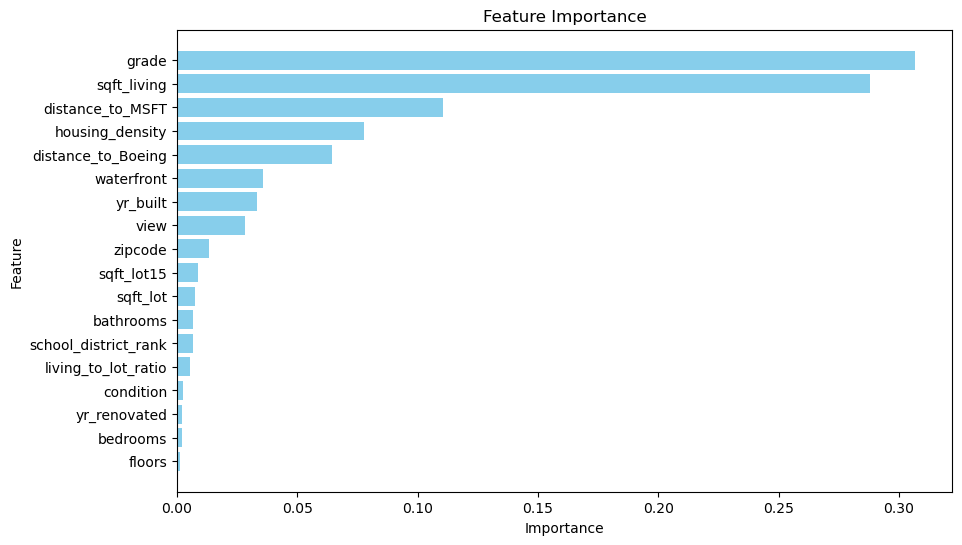

In [99]:
# Get feature importances from the fitted model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you've already trained your model and have feature importances
feature_importances = best_gbr.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()



In [100]:

# Set a threshold for feature importance
threshold = 0.01  # You can adjust this value

# Select features above the threshold
important_features = importance_df[importance_df['Importance'] > threshold]['Feature']

# Filter the dataset to only include important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# Retrain the model with the filtered dataset
best_gbr_filtered = GradientBoostingRegressor(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    n_estimators=best_params['n_estimators']
)
best_gbr_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred_filtered = best_gbr_filtered.predict(X_test_filtered)

# Evaluate the model
mse_filtered = mean_squared_error(y_test, y_pred_filtered)
r2_filtered = r2_score(y_test, y_pred_filtered)
mae_filtered = mean_absolute_error(y_test, y_pred_filtered)

print("Mean Squared Error after filtering:", mse_filtered)
print("R-squared after filtering:", r2_filtered)
print("Mean Absolute Error after filtering:", mae_filtered)

Mean Squared Error after filtering: 13986188477.376066
R-squared after filtering: 0.8913005954960734
Mean Absolute Error after filtering: 70094.96170821654


In [101]:
import pandas as pd

# Function to detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# Detect outliers in the dataset
outliers = detect_outliers_iqr(X_train_filtered)

# Print the number of outliers in each column
print(outliers.sum())

grade                 1536
sqft_living            438
distance_to_MSFT       890
housing_density        854
distance_to_Boeing     215
waterfront             125
yr_built                 0
view                  1708
zipcode                  0
dtype: int64


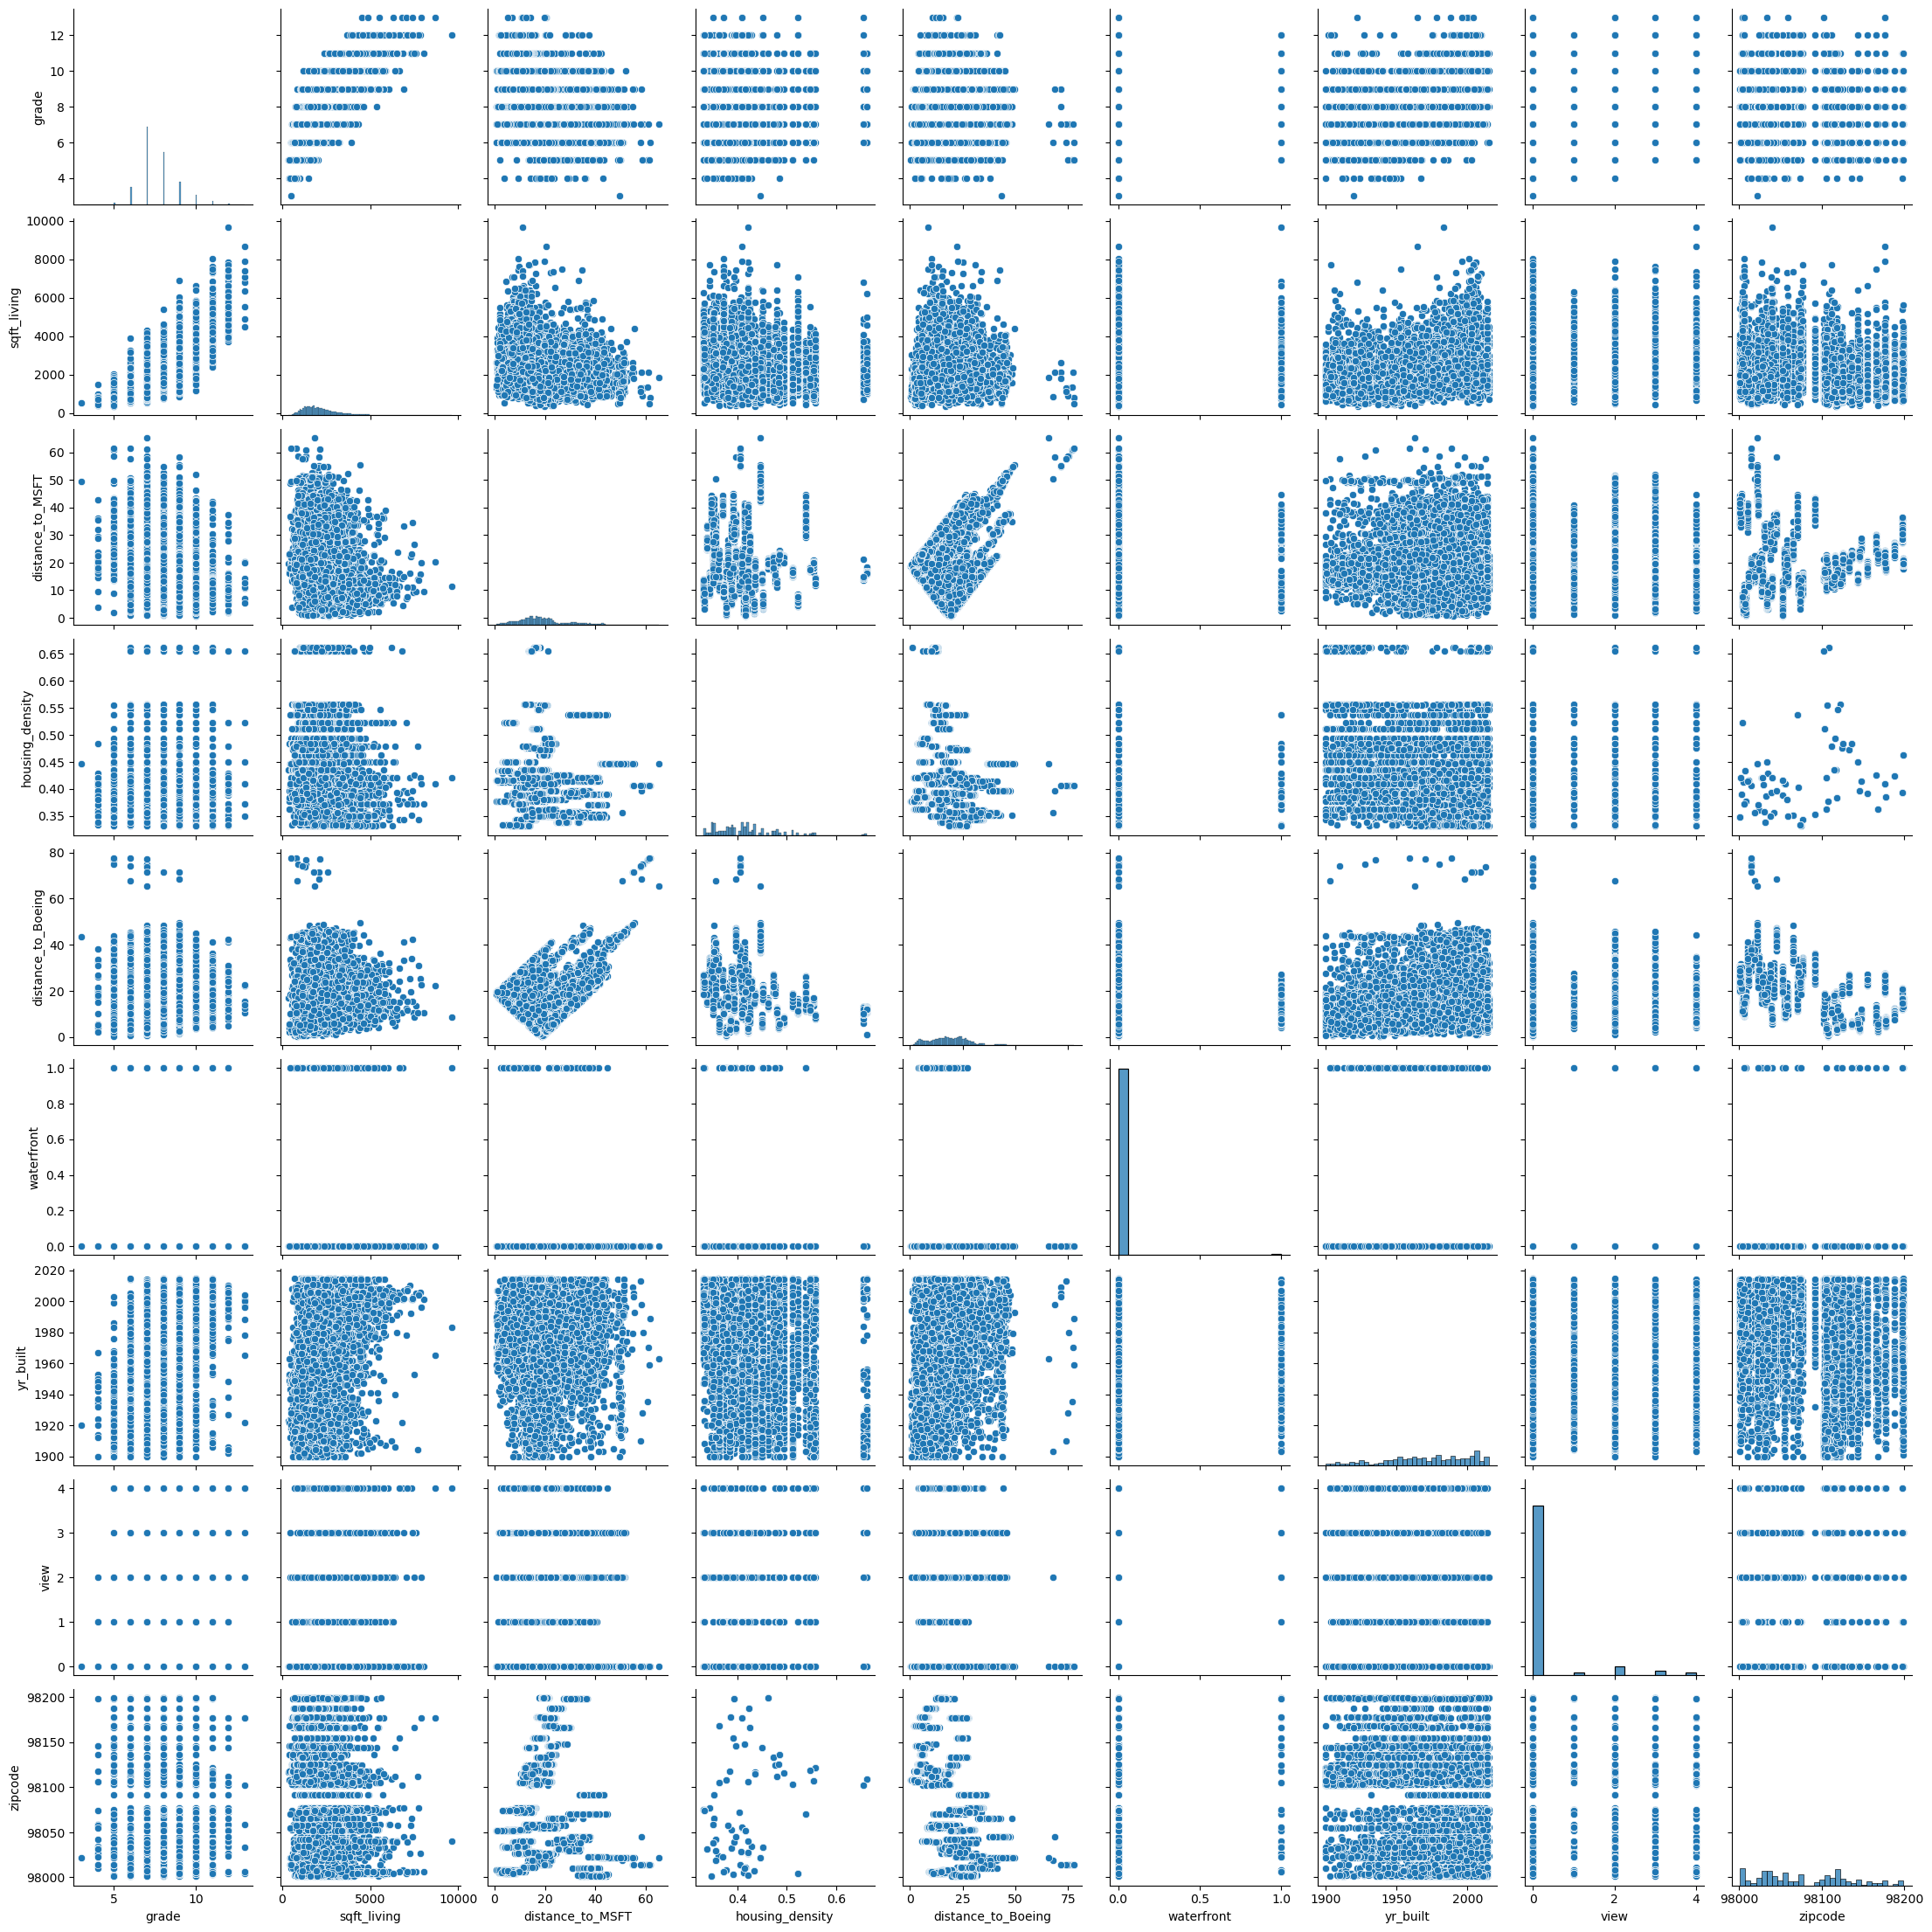

In [102]:
# Scatter plot for each pair of features
sns.pairplot(X_train_filtered)
plt.show()

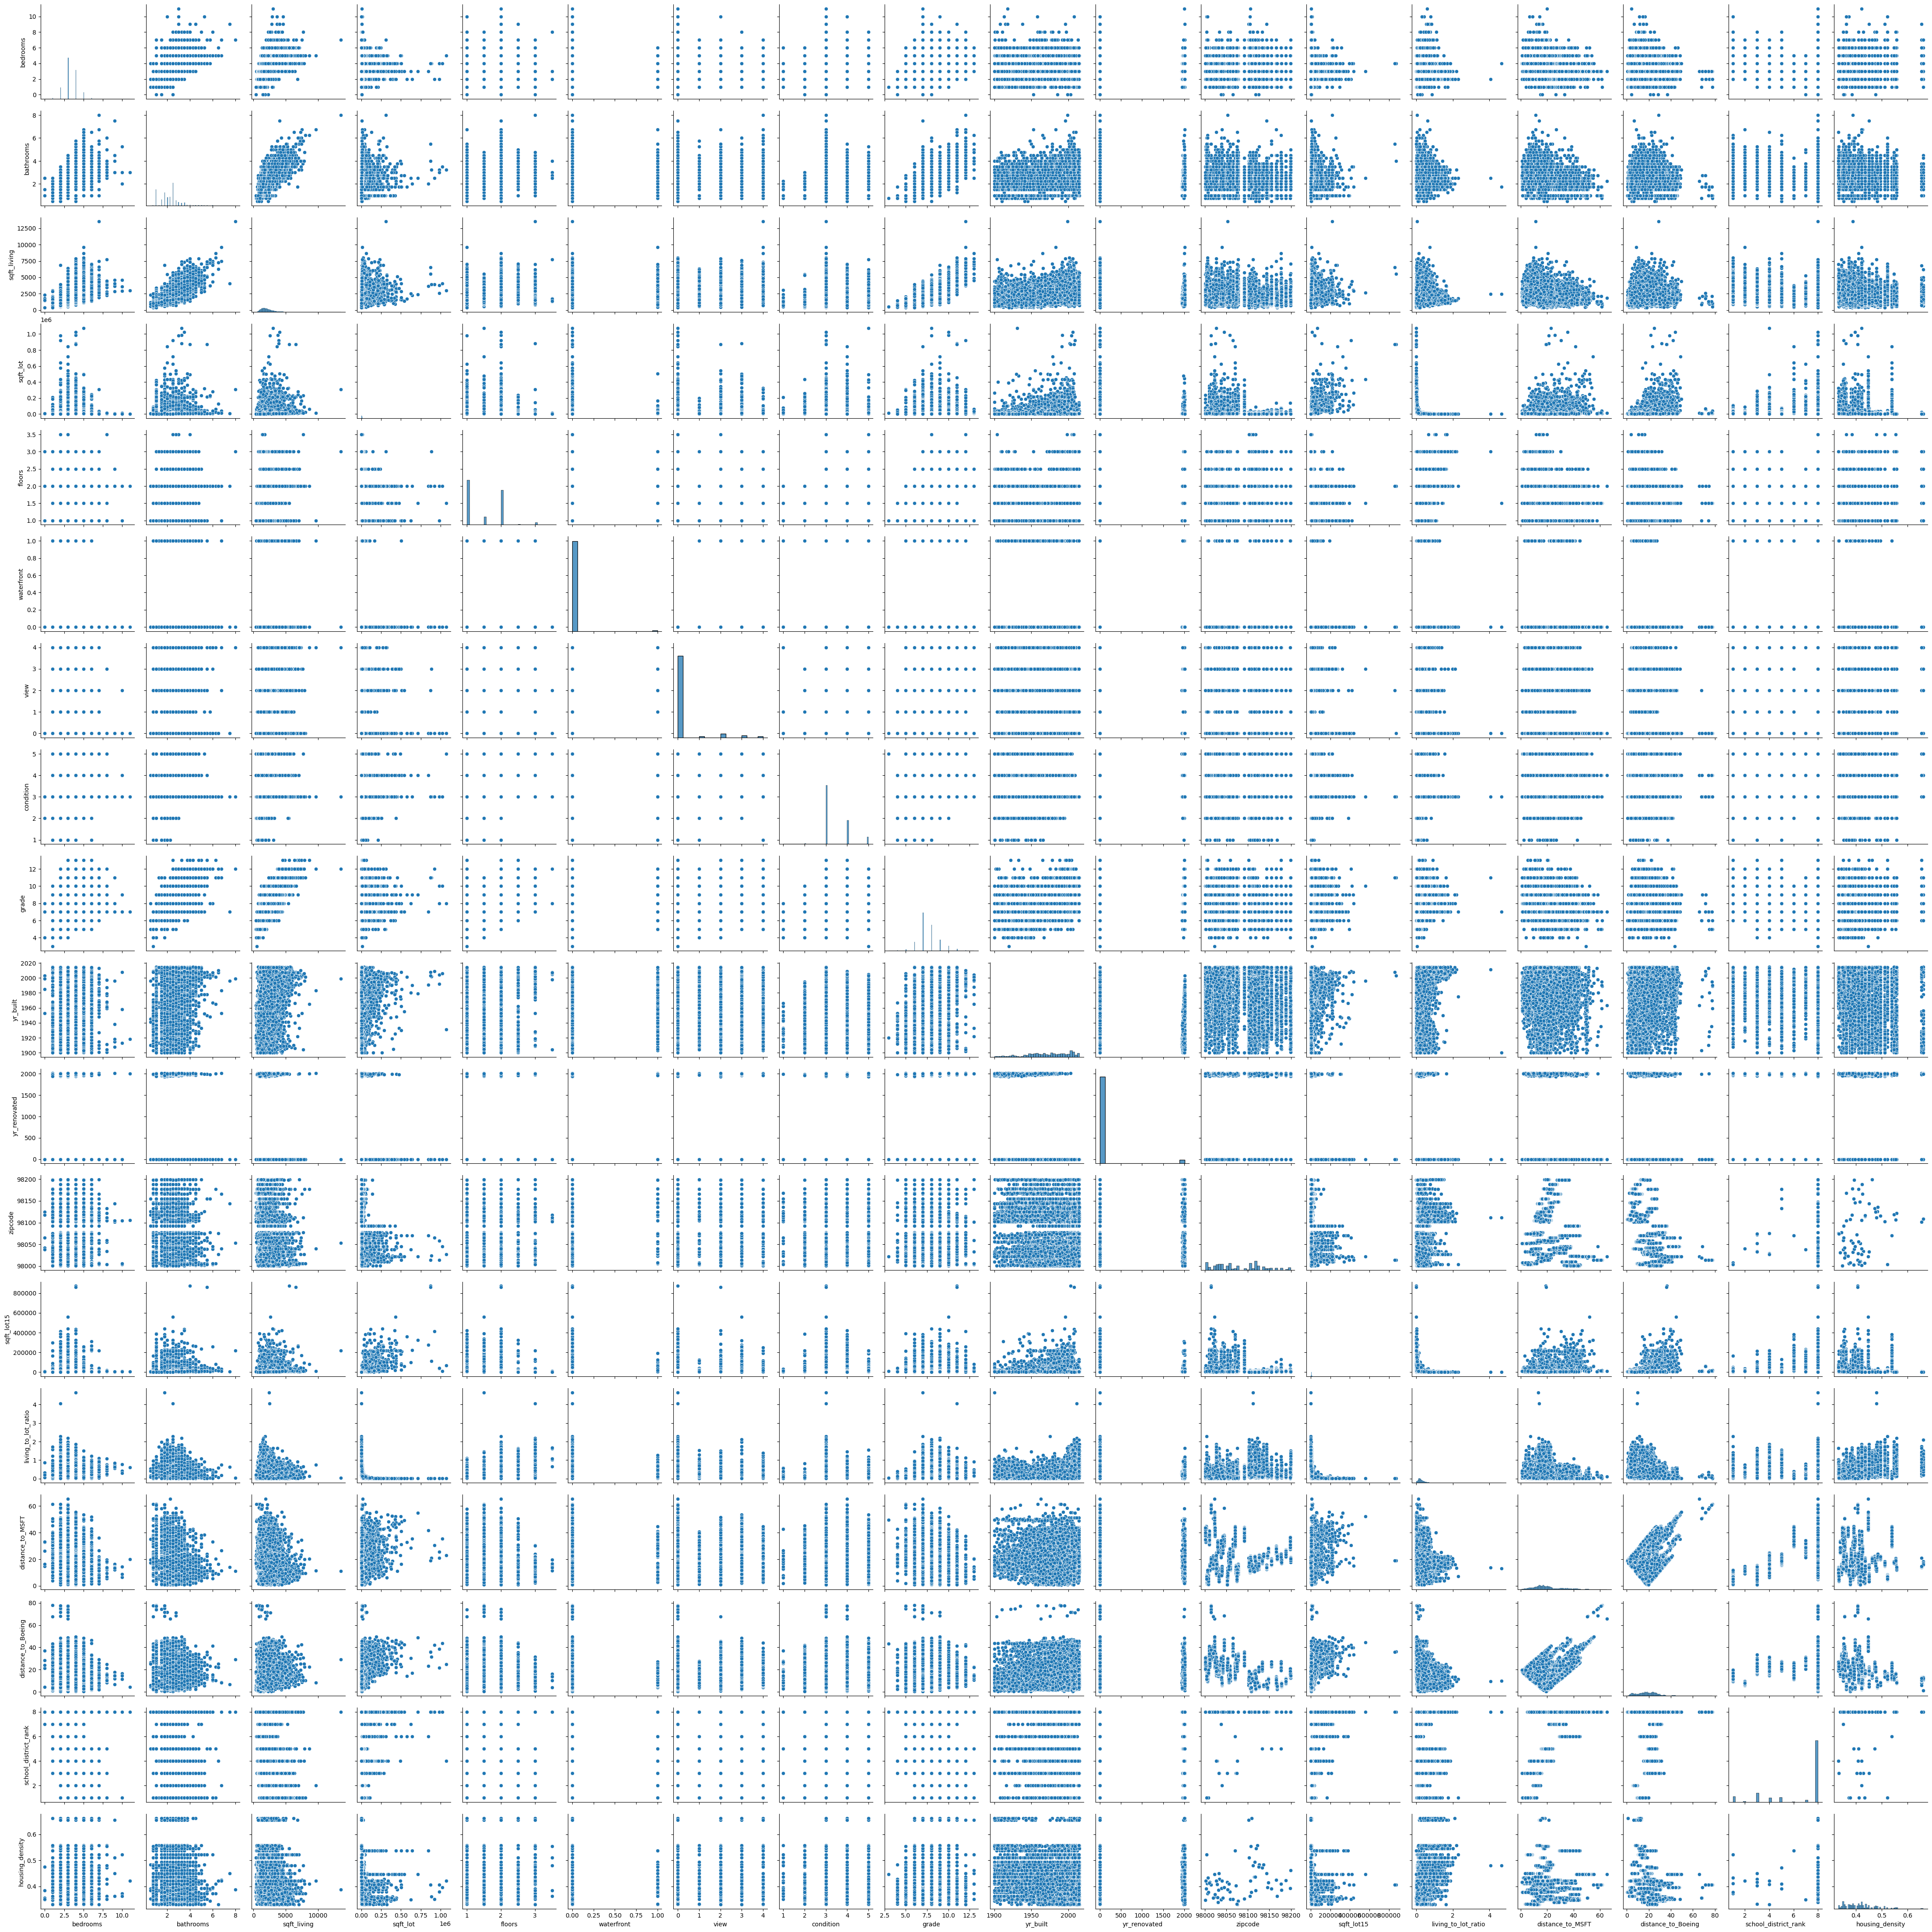

In [105]:
# Scatter plot for each pair of features
sns.pairplot(X)
plt.show()

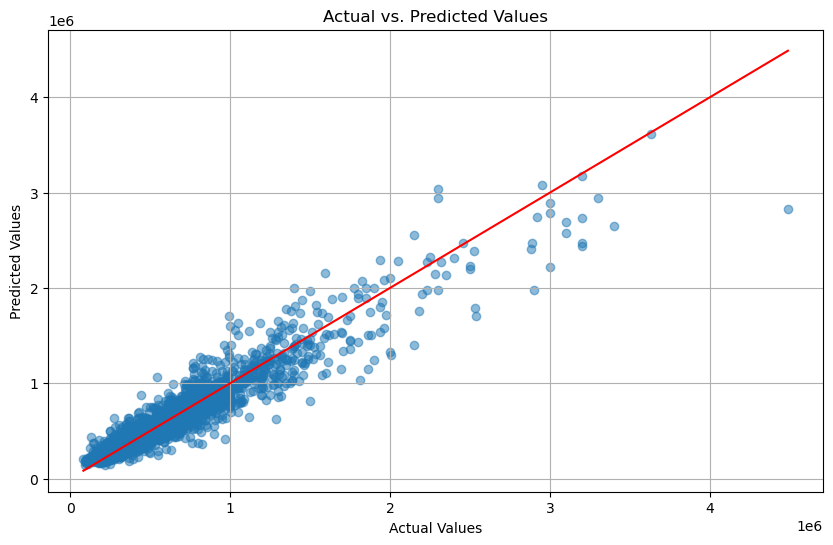

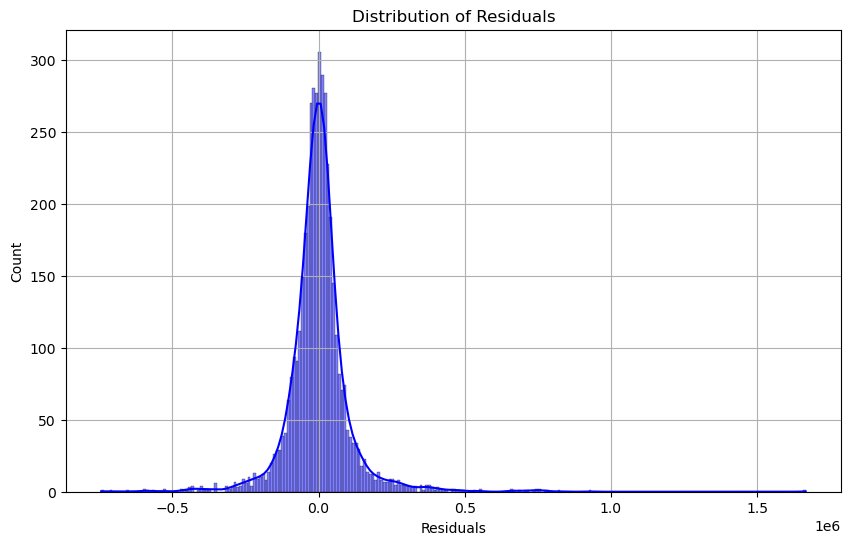

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()